# Tutorial: Simulate a model binary using stellar parameters from an isochrone

Phitter allows interpolating the stellar parameters in a model binary system from MIST isochrones.

This may be useful if the age of a binary or the host star population is well constrained. In these cases, all stellar parameters necessary for successful light curve calculation don't need to be specified: Phitter can interpolate along the MIST isochrone given just one parameter for a star (e.g.: initial mass).

## Imports

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# The following warning originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/Noh/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Volumes/Noh/models/cdbs/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Volumes/Noh/models/cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Noh/models/cdbs/grid/k93models/catalog.fits'

## Set up observation filters / passbands

For this example, let's generate photometry and RVs in HST's WFC3IR F153m passband.

In [2]:
filter_153m = filters.hst_f153m_filt()

## Set up stellar and binary system parameters

### Set up isochrone object

We're going to set up parameters for the component stars interpolated from a MIST isochrone. Let's choose an isochrone for an old star population located at the Galactic center…

We're interested in stars that are on the red giant branch stage, so we can specify to only use red giant stars.

In [2]:
# Object for interpolating stellar parameters from an isochrone

isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=3.0,
    dist=8e3*u.pc,
    filts_list=[filter_153m],
    ext_law='NL18',
)

NameError: name 'isoc_interp_params' is not defined

Let's choose stars along the RGB in this isochrone. We can interpolate using radius, since we can typically uniquely select a star using radius along the RGB.

In [ ]:
star1_params = isoc_stellar_params_obj.interp_star_params_rad(
    15,
)

print("Star 1 Parameters")
print(star1_params)

star2_params = isoc_stellar_params_obj.interp_star_params_rad(
    12,
)

print("Star 2 Parameters")
print(star2_params)

In [3]:
# Star parameters

bb_stellar_params_obj = blackbody_params.bb_stellar_params()

star1_params = bb_stellar_params_obj.calc_star_params(
    50 * u.solMass, 52 * u.solRad, 30_000 * u.K,
)

star2_params = bb_stellar_params_obj.calc_star_params(
    45 * u.solMass, 45 * u.solRad, 25_000 * u.K,
)

## Set up a binary parameters object

A separate object is set up to specify the parameters of the binary system

In [4]:
# Binary parameters
bin_params = binary_params.binary_params()

bin_params.period = 20.0 * u.d
bin_params.ecc = 0.05
bin_params.inc = 80.0 * u.deg
bin_params.t0 = 53_800.0

## Set up of observables to be calculated

We need to set up an observables object to specify the times and types of observables that need to be computed. For this example, let's compute flux in Keck K-band and RVs uniformly over the entire orbital phase of the binary.

In [5]:
# Set up model times
# Model times are in MJD here
model_phases = np.linspace(0, 1, num=100)
model_times = model_phases * bin_params.period.value + bin_params.t0

In [6]:
# Set up filter and observation type arrays for the model fluxes and RVs

kp_filt_arr = np.full(len(model_phases), filter_kp)
kp_type_arr = np.full(len(model_phases), 'phot')

rv_pri_filt_arr = np.full(len(model_phases), filter_kp)
rv_pri_type_arr = np.full(len(model_phases), 'rv_pri')

rv_sec_filt_arr = np.full(len(model_phases), filter_kp)
rv_sec_type_arr = np.full(len(model_phases), 'rv_sec')

In [7]:
# Now make arrays for all the times, filters, and observation types by concatenating the above arrays

obs_times = np.concatenate(
    (model_times, model_times, model_times),
)
obs_filts = np.concatenate(
    (kp_filt_arr, rv_pri_filt_arr, rv_sec_filt_arr,),
)
obs_types = np.concatenate(
    (kp_type_arr, rv_pri_type_arr, rv_sec_type_arr,),
)

In [8]:
# Finally, construct the observables object

model_observables = observables.observables(
    obs_times=obs_times,
    obs_filts=obs_filts, obs_types=obs_types,
)

## Compute the observables

First a model observation calculation object (`model_obs_calc`) has to be instantiated, with the observables as input parameters. This object will be carrying out the calculations.

In [9]:
# Object to perform the computation of flux and RVs

binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=True,
    print_diagnostics=False,
)

The modeled observables can then be simulated by inputting the stellar and binary parameters.

In [10]:
modeled_observables = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
)

## Process and plot the modeled observables

We can extract the different observables (flux and RVs of the primary and secondary object) from the output observables object. The observables object has numpy filters for each passband and data types that we can use for this.

In [11]:
# Fluxes in mags
modeled_kp_mags = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_kp]]

print(f'Kp-band mags: {modeled_kp_mags}')

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

print(f'Star 1 RVs: {modeled_rvs_star1} km/s')
print(f'Star 2 RVs: {modeled_rvs_star2} km/s')

Kp-band mags: [-7.5216657  -7.53972456 -7.5216657  -7.53734633 -7.58025251 -7.63846053
 -7.70128519 -7.76292451 -7.81979558 -7.87059033 -7.91483547 -7.95240259
 -7.98279677 -8.00657405 -8.02322366 -8.03172271 -8.03989347 -8.04860029
 -8.05727986 -8.06555845 -8.07347951 -8.08037767 -8.08609808 -8.09077146
 -8.09392676 -8.09520762 -8.09557121 -8.09430834 -8.09129548 -8.08705575
 -8.08157152 -8.07520896 -8.06824355 -8.06062953 -8.05298682 -8.0454252
 -8.03842117 -8.02654837 -8.00746362 -7.98222987 -7.95117477 -7.91450689
 -7.87241975 -7.82595624 -7.77576576 -7.72423427 -7.67567834 -7.63671158
 -7.61622983 -7.62138789 -7.65019962 -7.69433711 -7.74504379 -7.79678536
 -7.84628453 -7.89170482 -7.93219444 -7.96695628 -7.99580966 -8.01820065
 -8.03263269 -8.03764106 -8.04234726 -8.04695943 -8.05147356 -8.05582394
 -8.06005113 -8.06383782 -8.06744591 -8.07045797 -8.07319668 -8.07538945
 -8.0769968  -8.07774637 -8.07814732 -8.07781037 -8.07699569 -8.07555369
 -8.0735137  -8.07071239 -8.06746764 -

Now that we have the modeled observables, we can plot them for this model binary

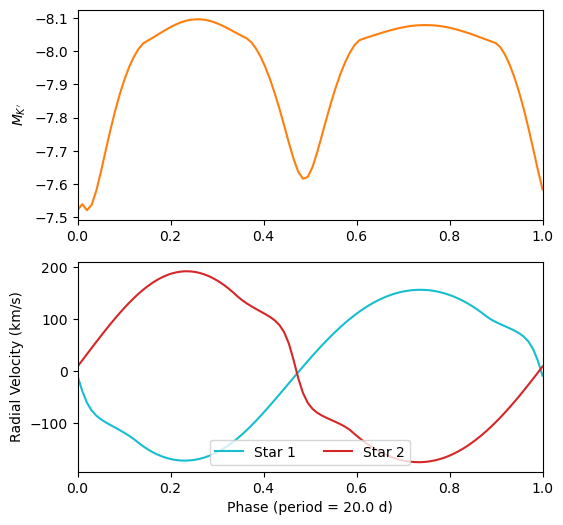

In [12]:
fig = plt.figure(figsize=(6,6))

# Kp mags subplot
ax_mag_kp = fig.add_subplot(2,1,1)

ax_mag_kp.plot(
    model_phases, modeled_kp_mags,
    '-', color='C1',
)

ax_mag_kp.set_xlim([0, 1])

ax_mag_kp.invert_yaxis()
ax_mag_kp.set_ylabel(r"$M_{K'}$")

# RVs subplot
ax_rvs = fig.add_subplot(2,1,2)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)


## Bonus: make mesh plots to aide visualization

The above plot is great to see the modeled observables. But it can be helpful to see what the modeled binary system looks like. Let's add simulate some mesh outlines of the stellar surfaces to see what this model binary looks like…

We need to make a figure first where we'll do the plotting. We can be extra specific about the layout of the mesh plots in this figure, so let's do that!

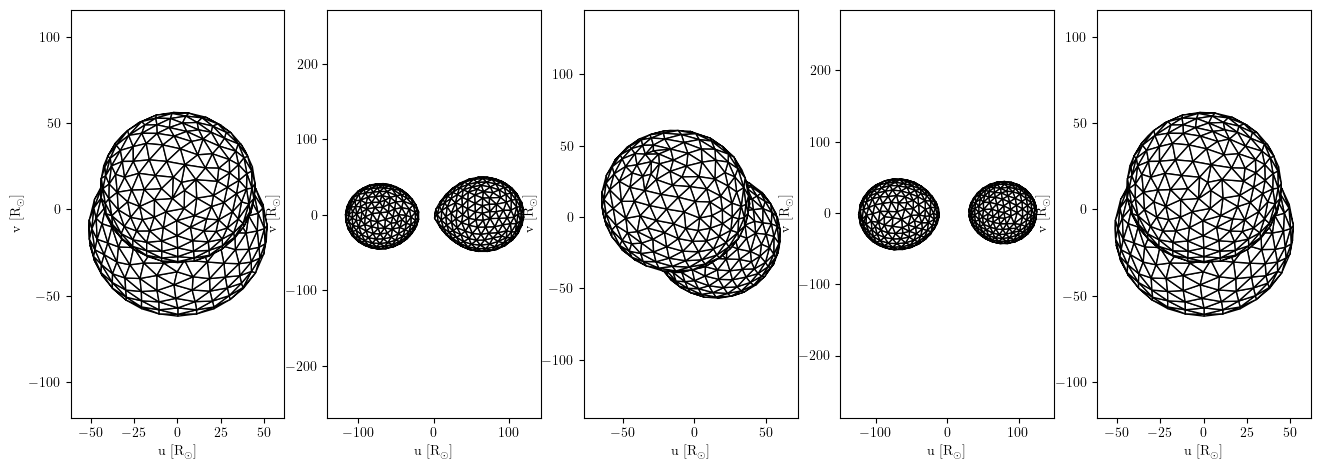

In [13]:
# Set up figure and specificy mesh plot outputs

fig = plt.figure(figsize=(8,8))
gs = plt.GridSpec(5, 5,)

mesh_plot_phases = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

modeled_observables, mesh_plot_out, fig = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
    make_mesh_plots=True,
    mesh_plot_phases=mesh_plot_phases,
    mesh_plot_fig=fig,
    mesh_plot_subplot_grid=(3,5),
    mesh_plot_subplot_grid_indexes=np.array([1, 2, 3, 4, 5,]),
    num_triangles=500,
)

# The mesh subplots show here since we have matplotlib inline enabled

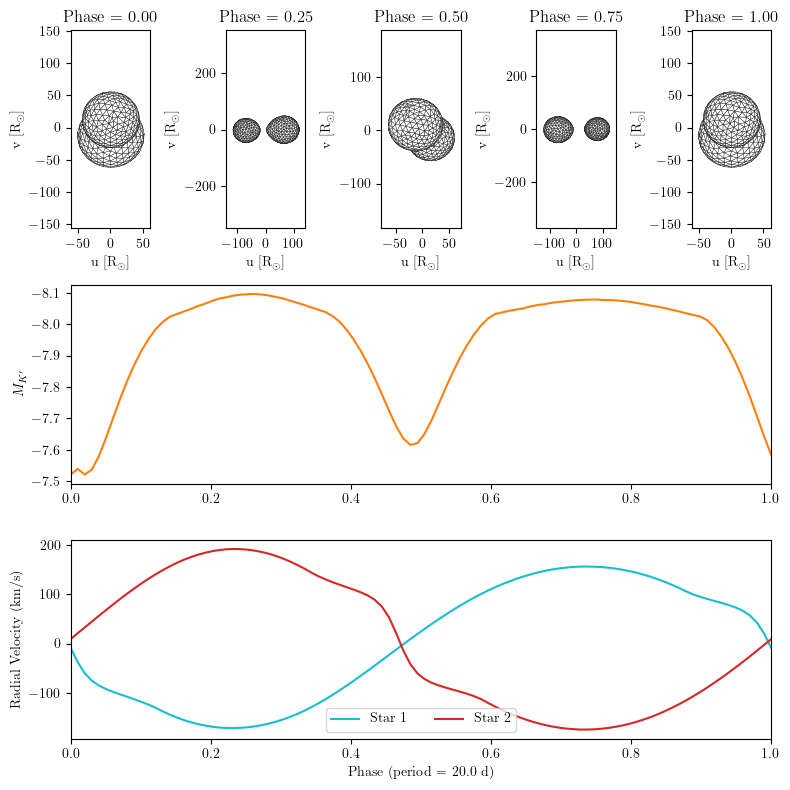

In [14]:
# Finish constructing the whole figure

# Fluxes in mags
modeled_kp_mags = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_kp]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

# Label the mesh subplots
# # Remove empty axes
# for ax in fig.axes:
#     if ax.get_xlabel() == '':
#         ax.remove()

# # Make mesh axes share axes
# mesh_axes = []

for ax_index, phase in enumerate(mesh_plot_phases):
    ax = fig.axes[ax_index]
    
    ax.set_title(f'Phase = {phase:.2f}')
    
    # Decrease linewidths of the triangles in the mesh, for legibility in final plot
    for child in ax.get_children():
        if isinstance(child, mpl.collections.PolyCollection):
            child.set(lw=0.25)
    
    # mesh_axes.append(ax)

# Draw observables subplots
# Kp mags subplot
ax_mag_kp = fig.add_subplot(3,1,2)

ax_mag_kp.plot(
    model_phases, modeled_kp_mags,
    '-', color='C1',
)

ax_mag_kp.set_xlim([0, 1])

ax_mag_kp.invert_yaxis()
ax_mag_kp.set_ylabel(r"$M_{K'}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)

fig.set_size_inches(8, 8)
fig.tight_layout()

fig